# Time Series Modeling

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from random import gauss as gs
import datetime
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

## White Noise

The idea behind white noise is that it is truly random.

We don't want white noise to describe our model per se, but we *do* want it to describe our model *error*.

Can you explain these truisms?

In [2]:
# Let's make some white noise!

rands = []
for _ in range(1000):
    rands.append(gs(0, 1))
series = pd.Series(rands)

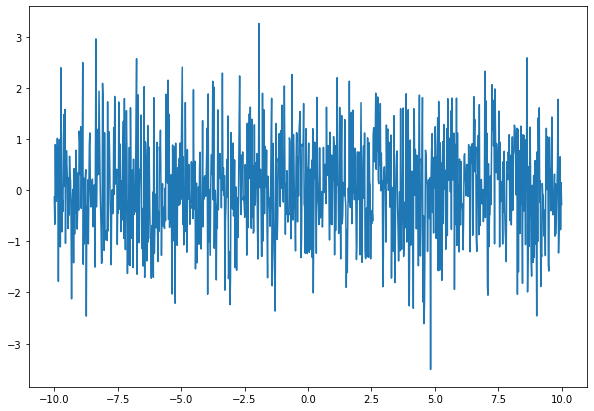

In [3]:
X = np.linspace(-10, 10, 1000)
plt.figure(figsize=(10, 7))
plt.plot(X, series);

What happens if we do a seasonal decomposition on this?

In [4]:
time_index = pd.to_datetime(series.index, unit='D')

In [5]:
series.index = time_index
decomp_white = sm.tsa.seasonal_decompose(series)

//anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


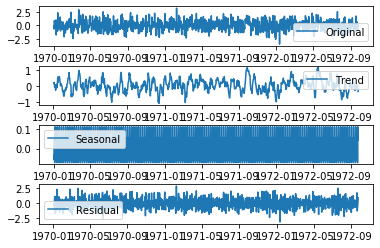

In [6]:
plt.subplot(411)
plt.plot(series.index, decomp_white.observed, label='Original')
plt.legend()
plt.subplot(412)
plt.plot(series.index, decomp_white.trend, label='Trend')
plt.legend()
plt.subplot(413)
plt.plot(series.index, decomp_white.seasonal, label='Seasonal')
plt.legend()
plt.subplot(414)
plt.plot(series.index, decomp_white.resid, label='Residual')
plt.legend()
plt.subplots_adjust(hspace=0.5);

## Football Data

In [7]:
fb = pd.read_csv('data/google-trends_football_us.csv').iloc[1:, :]
fb.columns = ['counts']

In [8]:
fb['counts'] = fb['counts'].replace('<1', '0')
fb['counts'] = fb['counts'].astype(int)

In [9]:
fb.head()

,counts
2004-01,12
2004-02,9
2004-03,7
2004-04,8
2004-05,8


### Series as Both Predictor and Target?

Often, the phenomenon we want to capture with a time series is a dataset being correlated with *itself*.

Well, of course every dataset is perfectly correlated with itself. But what we're after now is the idea that a series is correlated with *earlier versions* of itself.

Consider the problem of trying to predict tomorrow's closing price for some stock on the market. One may consider lots of features, like what sort of company it is to which the stock belongs or whether that company has been in the news recently.

But it is very often the case that one of the most helpful predictors of tomorrow's price is *today's* price. And so we want to build a model where one of our predictors is an earlier version of our target.

In [10]:
fb.rolling(window=2).mean().head()

,counts
2004-01,NaN
2004-02,10.5
2004-03,8.0
2004-04,7.5
2004-05,8.0


In [11]:
fb['roll_avg'] = fb.rolling(window=2).mean()

fb.corr()

,counts,roll_avg
counts,1.000000,0.938216
roll_avg,0.938216,1.000000


In [12]:
lr = LinearRegression()

lr.fit(fb[['roll_avg']][1:], fb['counts'][1:])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

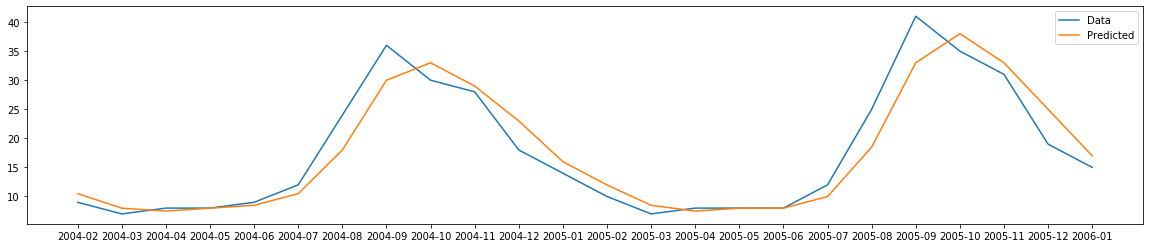

In [13]:
plt.figure(figsize=(20, 4))
plt.plot(fb.index[1:25], fb['counts'][1:25], label='Data')
plt.plot(fb.index[1:25], lr.predict(fb[['roll_avg']][1:25]), label='Predicted')
plt.legend();

### Autocorrelation and Partial Autocorrelation Functions

Pandas and statsmodels offer autocorrelation (ACF) and partial autocorrelation (PACF) plotting tools. The idea here is to look at the correlation of a series with itself for some particular interval or *lag*. The key difference between the full and the partial autocorrelation functions is that the partial autocorrelation function ignores intervening intervals. For more, see [this post](https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/).

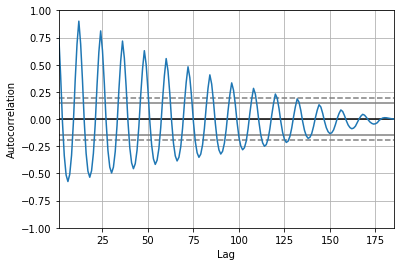

In [15]:
pd.plotting.autocorrelation_plot(fb['counts']);

#### Partial Autocorrelation

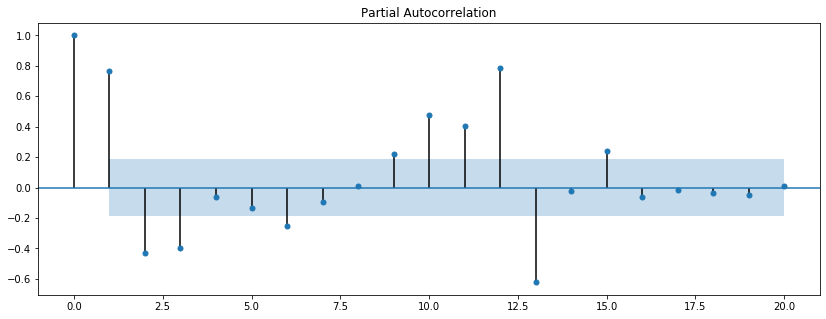

In [17]:
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = 14, 5

plot_pacf(fb['counts'], lags=20, alpha=0.01);

## ARMA Modeling

'AR' is for "Auto-Regressive": The prediction for today will be a function of the value for previous days.

The number of lag periods we want to include will be a parameter in the statsmodels model object ("p"). Looking at the PACF can help us decide on an appropriate p.

'MA' is for "Moving Average": The prediction for today will be a function of the rolling mean.

The number of average terms we want to include will be a parameter in the statsmodels model object ("q"). Looking at the ACF can help us decide on an appropriate q.

For some technical details, see [this page](https://en.wikipedia.org/wiki/Autoregressive%E2%80%93moving-average_model#Choosing_p_and_q).

In [19]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA

### Stationarity and the Dickey-Fuller Test

ARMA models assume that the time series is *stationary*, which means that its statistical properties are not a (meaningful) function of time.

It may seem counterintuitive that, for modeling purposes, we want our time series not to be a function of time! But the basic idea is the familiar one that we want our datapoints to be mutually *independent*. For more on this topic, see [here](https://stats.stackexchange.com/questions/19715/why-does-a-time-series-have-to-be-stationary).

One way of testing for stationarity is to use the Dickey-Fuller Test. The statsmodels version returns the test statistic and a p-value, relative to the null hypothesis that the series in question is NOT stationary. For more, see [this Wikipedia page](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test).

In [20]:
# Presumably, our football series is not stationary. Let's check.

adfuller(fb['counts'], autolag=None)

(0.26146040618615873,
 0.9755055540608923,
 14,
 170,
 {'1%': -3.469413468959902,
  '5%': -2.8786964197028295,
  '10%': -2.5759166089965397})

But let's check the stationarity of the *differences* of our data:

In [21]:
fb['counts'].head()

2004-01    12
2004-02     9
2004-03     7
2004-04     8
2004-05     8
Name: counts, dtype: int64

In [22]:
fb['counts'].diff().head()

2004-01    NaN
2004-02   -3.0
2004-03   -2.0
2004-04    1.0
2004-05    0.0
Name: counts, dtype: float64

In [23]:
adfuller(fb['counts'].diff()[1:], autolag=None)

(-5.778990693575886,
 5.178749631361898e-07,
 14,
 169,
 {'1%': -3.469648263987657,
  '5%': -2.878798906308495,
  '10%': -2.5759713094779593})

### Building the Model

In [26]:
p=2
q=0
ar = ARMA(fb['counts'].diff().values[2:], (p, q)).fit()

//anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
//anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
//anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future

In [27]:
ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  183
Model:                     ARMA(2, 0)   Log Likelihood                -740.679
Method:                       css-mle   S.D. of innovations             13.850
Date:                Thu, 26 Sep 2019   AIC                           1489.358
Time:                        14:56:19   BIC                           1502.196
Sample:                             0   HQIC                          1494.562
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0060      1.458     -0.004      0.997      -2.864       2.852
ar.L1.y        0.2334      0.074      3.174      0.002       0.089       0.377
ar.L2.y        0.0664      0.073      0.905      0.367      -0.077       0.210
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.5029           +0.0000j            2.5029            0.0000
AR.2           -6.0190           +0.0000j            6.0190            0.5000
-----------------------------------------------------------------------------
"""

#### `np.cumsum()`
Let's use `np.cumsum()` to add up our predictions!

In [28]:
fb['counts'].head()

2004-01    12
2004-02     9
2004-03     7
2004-04     8
2004-05     8
Name: counts, dtype: int64

In [29]:
np.cumsum(fb['counts']).head()

2004-01    12
2004-02    21
2004-03    28
2004-04    36
2004-05    44
Name: counts, dtype: int64

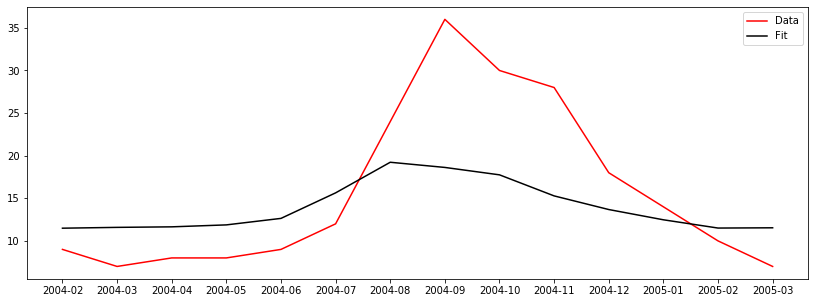

In [33]:
preds = ar.predict()
full = fb['counts'].values[0] +  np.cumsum(preds)

f, a = plt.subplots()
a.plot(fb.index[1:15], fb['counts'][1:15], 'r', label='Data')
a.plot(fb.index[1:15], full[1:15], 'k', label='Fit')
plt.legend();

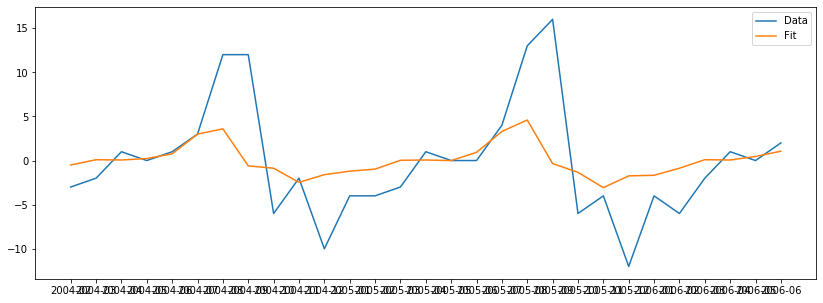

In [34]:
f, a = plt.subplots()
a.plot(fb.index[1:30], fb['counts'].diff()[1:30], label='Data')
a.plot(fb.index[1:30], preds[1:30], label='Fit')
plt.legend();

### Unemployment Data

In [35]:
data = pd.read_csv('data/seasonally-adjusted-quarterly-us.csv')

In [36]:
data.columns = ['year_q', 'unemp_rate']
data['unemp_rate'] = data['unemp_rate'].map(lambda x:\
                                            float(str(x).replace('%', '')))
data.dropna(inplace=True)

In [37]:
data['date'] = pd.to_datetime(data['year_q']).dt.to_period('Q')
data.set_index('date', inplace=True, drop=True)

In [38]:
data.head()

,year_q,unemp_rate
date,,
1948Q1,1948Q1,3.733
1948Q2,1948Q2,3.667
1948Q3,1948Q3,3.767
1948Q4,1948Q4,3.833
1949Q1,1949Q1,4.667


In [39]:
p=2
q=0
ar2 = ARMA(data['unemp_rate'].diff()[1:].values, (p, q)).fit()

//anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
//anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
//anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future

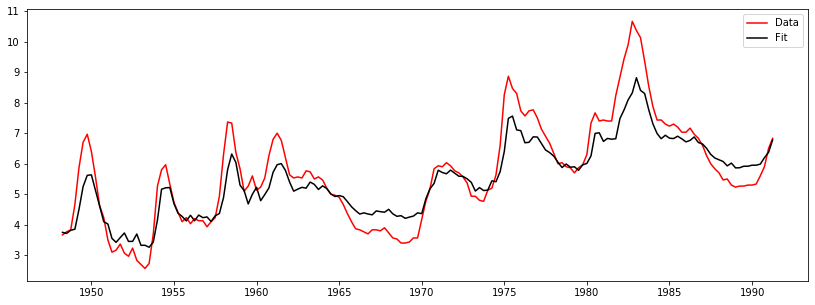

In [40]:
preds2 = ar2.predict()
full2 = data['unemp_rate'].values[0] + np.cumsum(preds2)

f, a = plt.subplots()
a.plot(data.index.to_timestamp()[1:], data['unemp_rate'][1:], 'r', label='Data')
a.plot(data.index.to_timestamp()[1:], full2, 'k', label='Fit')
plt.legend();

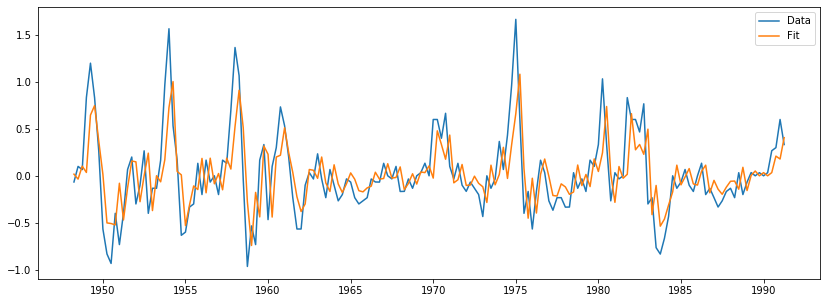

In [41]:
f, a = plt.subplots()
a.plot(data.index.to_timestamp()[1:], data['unemp_rate'].diff()[1:], label='Data')
a.plot(data.index.to_timestamp()[1:], preds2, label='Fit')
plt.legend();